Dataset Loaded Successfully!

Shape of Dataset: (20, 5)

Columns in Dataset:
['PatientID', 'Age', 'BloodPressure', 'SugarLevel', 'Weight']

Checking for Missing Values...
PatientID        0
Age              0
BloodPressure    0
SugarLevel       0
Weight           0
dtype: int64

Missing Values Handled Successfully!

Duplicates Removed! New Shape: (20, 5)

Outliers Handled Using IQR Method!

Data Normalized Using StandardScaler!

Feature Engineering Completed Successfully!


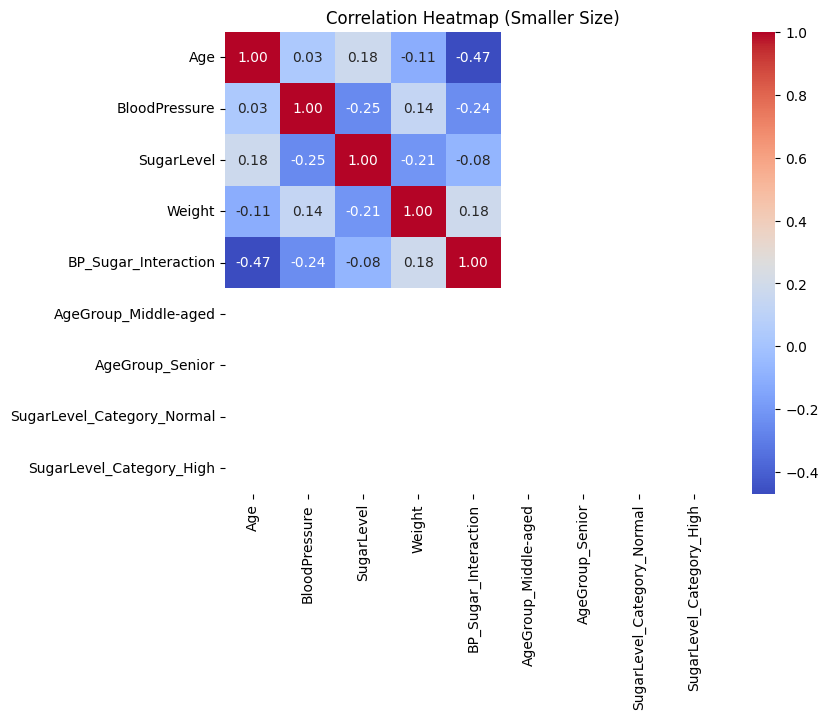


Correlation Analysis Completed!

Top 5 Selected Features:  ['Age', 'BloodPressure', 'Weight', 'BP_Sugar_Interaction', 'SugarLevel_Category_High']
Feature Selection Completed Successfully!


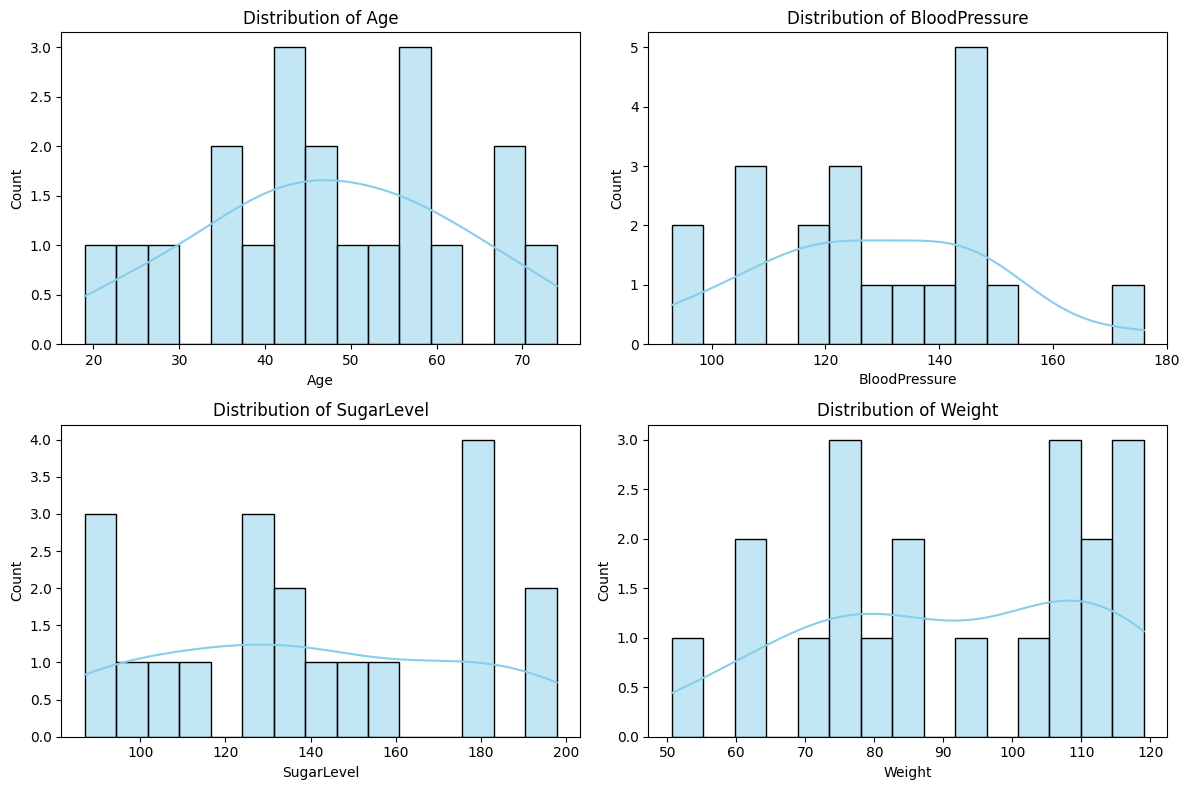


Data Distribution Visualized!

Data Split Completed for Modeling!
X_train Shape: (16, 7)
X_test Shape: (4, 7)
y_train Shape: (16,)
y_test Shape: (4,)

SUMMARY OF DATA CLEANING PROCESS COMPLETED!


In [1]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# SUPPRESS WARNINGS
warnings.filterwarnings("ignore")

# 1. LOAD THE HEALTHCARE DATASET
file_path = "/content/healthcare_data.csv"
data = pd.read_csv(file_path)

print("Dataset Loaded Successfully!")
print(f"\nShape of Dataset: {data.shape}")
print(f"\nColumns in Dataset:\n{data.columns.to_list()}")

# 2. DATA CLEANING STARTS HERE

# CHECK FOR MISSING VALUES
print("\nChecking for Missing Values...")
missing_summary = data.isnull().sum()
print(missing_summary)

# FILL MISSING VALUES

# For numerical columns: fill with mean
for col in data.select_dtypes(include=np.number).columns:
    data[col].fillna(data[col].mean(), inplace=True)

# For categorical columns: fill with mode
for col in data.select_dtypes(include="object").columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

print("\nMissing Values Handled Successfully!")

# REMOVE DUPLICATES
data.drop_duplicates(inplace=True)
print(f"\nDuplicates Removed! New Shape: {data.shape}")

# 3. HANDLE OUTLIERS USING IQR
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Identify numeric columns to handle outliers
numeric_columns = ["Age", "BloodPressure", "SugarLevel", "Weight"]
data = handle_outliers(data, numeric_columns)
print("\nOutliers Handled Using IQR Method!")

# 4. NORMALIZE / SCALE DATA
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[numeric_columns]), columns=numeric_columns)

# Add PatientID back after scaling
data_scaled["PatientID"] = data["PatientID"].values
print("\nData Normalized Using StandardScaler!")

# 5. FEATURE ENGINEERING

# Create Age Group (Young, Middle-aged, Senior)
data_scaled["AgeGroup"] = pd.cut(data_scaled["Age"], bins=[0, 30, 50, 100], labels=["Young", "Middle-aged", "Senior"])

# Interaction Feature: BloodPressure * SugarLevel
data_scaled["BP_Sugar_Interaction"] = data_scaled["BloodPressure"] * data_scaled["SugarLevel"]

# Binning SugarLevel into Low, Normal, High
data_scaled["SugarLevel_Category"] = pd.cut(data_scaled["SugarLevel"], bins=[0, 100, 140, 200], labels=["Low", "Normal", "High"])

# One-hot encoding for categorical features
data_encoded = pd.get_dummies(data_scaled, columns=["AgeGroup", "SugarLevel_Category"], drop_first=True)

# Drop unnecessary columns before feature selection
data_encoded.drop(columns=["PatientID"], inplace=True)
print("\nFeature Engineering Completed Successfully!")

# 6. CORRELATION ANALYSIS
plt.figure(figsize=(8, 6))
sns.heatmap(data_encoded.corr(), annot=True, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap (Smaller Size)")
plt.show()
print("\nCorrelation Analysis Completed!")

# 7. FEATURE SELECTION

# Define X and y for feature selection
X_new = data_encoded.drop(columns=["SugarLevel"])
y_new = (data_encoded["SugarLevel"] > data_encoded["SugarLevel"].mean()).astype(int)

# Select top 5 features using SelectKBest (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X_new, y_new)

# Get selected feature names
selected_features = X_new.columns[selector.get_support()]

print("\nTop 5 Selected Features: ", list(selected_features))
print("Feature Selection Completed Successfully!")

# 8. VISUALIZATIONS OF DISTRIBUTIONS
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data[col], kde=True, bins=15, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()
print("\nData Distribution Visualized!")

# 9. SPLIT DATA FOR MODELING
X = data_scaled.drop(columns=["PatientID"])
y = (data_scaled["SugarLevel"] > data_scaled["SugarLevel"].mean()).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData Split Completed for Modeling!")
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")

# 10. DATA SUMMARY
data_summary = {
    "Outlier Handled Data": data.head(),
    "Normalized Data": data_scaled.head(),
    "Selected Features": list(selected_features),
    "X_train Shape": X_train.shape,
    "X_test Shape": X_test.shape,
    "y_train Shape": y_train.shape,
    "y_test Shape": y_test.shape
}

print("\nSUMMARY OF DATA CLEANING PROCESS COMPLETED!")
